In [3]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import yfinance as yf

In [4]:
os.getcwd()
os.chdir("C:/Users/Administrator/Desktop/Projects/SPY Personal Project/data")

In [5]:
spy = yf.download("SPY", start="2000-01-01", end="2024-12-31")
cpi = pd.read_csv("cpi.csv")

[*********************100%***********************]  1 of 1 completed


In [6]:
spy.to_csv("spy.csv")

In [7]:
cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      934 non-null    object 
 1   CPIAUCSL  934 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.7+ KB


In [8]:
print(spy.head(5))
print(cpi.head(5))
print(cpi.tail(5))

                 Open       High         Low     Close  Adj Close    Volume
Date                                                                       
2000-01-03  148.25000  148.25000  143.875000  145.4375  93.004929   8164300
2000-01-04  143.53125  144.06250  139.640625  139.7500  89.367836   8089800
2000-01-05  139.93750  141.53125  137.250000  140.0000  89.527718  12177900
2000-01-06  139.62500  141.50000  137.750000  137.7500  88.088867   6227200
2000-01-07  140.31250  145.75000  140.062500  145.7500  93.204720   8066500
         DATE  CPIAUCSL
0  1947-01-01     21.48
1  1947-02-01     21.62
2  1947-03-01     22.00
3  1947-04-01     22.00
4  1947-05-01     21.95
           DATE  CPIAUCSL
929  2024-06-01   313.049
930  2024-07-01   313.534
931  2024-08-01   314.121
932  2024-09-01   314.686
933  2024-10-01   315.454


In [9]:
# Clean and preprocess inflation and SPY data
cpi = cpi.rename(columns={"DATE": "date", "CPIAUCSL": "cpi_value"})
cpi["date"] = pd.to_datetime(cpi["date"])
cpi["cpi_value"] = cpi["cpi_value"].astype(float).round(2)
cpi = cpi[(cpi["date"] >= "2000-01-01")]
cpi.reset_index(inplace=True, drop=True)

spy = spy.drop(columns=["Open", "High", "Low", "Close", "Volume"])
spy.reset_index(inplace=True)
spy = spy.rename(columns={"Adj Close": "close_price", "Date": "date"})
spy["date"] = pd.to_datetime(spy["date"])
spy["close_price"] = spy["close_price"].round(2)

## Calculating SPY Prices adjusted for inflation

The formula is: 

$$\text{Inflation Adjusted Price} = \text{Nominal SPY Price} \times \left(\frac{\text{Current CPI}}{\text{Historical CPI}}\right)$$

We will find the adjustment factor which is $ \frac{\text{Current CPI}}{\text{Historical CPI}} $


In [10]:
current_cpi = cpi["cpi_value"].iloc[0]
cpi["adj_fac"] = current_cpi / cpi["cpi_value"]
cpi

,date,cpi_value,adj_fac
0,2000-01-01,169.30,1.000000
1,2000-02-01,170.00,0.995882
2,2000-03-01,171.00,0.990058
3,2000-04-01,170.90,0.990638
4,2000-05-01,171.20,0.988902
...,...,...,...
293,2024-06-01,313.05,0.540808
294,2024-07-01,313.53,0.539980
295,2024-08-01,314.12,0.538966
296,2024-09-01,314.69,0.537990


In [11]:
spy

,date,close_price
0,2000-01-03,93.00
1,2000-01-04,89.37
2,2000-01-05,89.53
3,2000-01-06,88.09
4,2000-01-07,93.20
...,...,...
6257,2024-11-14,593.35
6258,2024-11-15,585.75
6259,2024-11-18,588.15
6260,2024-11-19,590.30


In [12]:
spy = spy.merge(cpi, on="date")
spy = spy.drop(columns="cpi_value")

In [13]:
print(spy)

          date  close_price   adj_fac
0   2000-02-01        90.13  0.995882
1   2000-03-01        88.53  0.990058
2   2000-05-01        94.28  0.988902
3   2000-06-01        93.16  0.983159
4   2000-08-01        92.46  0.980313
..         ...          ...       ...
188 2024-04-01       518.89  0.540532
189 2024-05-01       497.22  0.540497
190 2024-07-01       543.67  0.539980
191 2024-08-01       541.35  0.538966
192 2024-10-01       568.62  0.536694

[193 rows x 3 columns]


In [14]:
full_months = pd.date_range(start=spy["date"].min(), end=spy["date"].max(), freq="MS")

# Create a DataFrame for the full list of first-of-month dates
full_months_df = pd.DataFrame({"date": full_months})

# Merge the full list with SPY data to identify missing first-of-the-month rows
spy = pd.merge(full_months_df, spy, on="date", how="left")

# Forward fill the 'close_price' and 'adj_fac' columns
spy["close_price"] = spy["close_price"].fillna(method="ffill")
spy["adj_fac"] = spy["adj_fac"].fillna(method="ffill")

# Create the new row as a DataFrame
new_row = pd.DataFrame(
    {
        "date": ["2000-01-01"],
        "close_price": [93.92],
        "adj_fac": [1],
        "real_price": [93.92],
    }
)

# Ensure the new row has the same column order as the original DataFrame
spy = pd.concat([new_row, spy], ignore_index=True)

# Ensure 'date' is in datetime format for consistency
spy["date"] = pd.to_datetime(spy["date"])

# Sort by date if necessary (not needed here since we know this row is the first)
spy = spy.sort_values(by="date").reset_index(drop=True)

spy["real_price"] = spy["close_price"] * spy["adj_fac"]
spy

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27604\3817809380.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy['close_price'] = spy['close_price'].fillna(method='ffill')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27604\3817809380.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy['adj_fac'] = spy['adj_fac'].fillna(method='ffill')


,date,close_price,adj_fac,real_price
0,2000-01-01,93.92,1.000000,93.920000
1,2000-02-01,90.13,0.995882,89.758876
2,2000-03-01,88.53,0.990058,87.649877
3,2000-04-01,88.53,0.990058,87.649877
4,2000-05-01,94.28,0.988902,93.233668
...,...,...,...,...
293,2024-06-01,497.22,0.540497,268.746116
294,2024-07-01,543.67,0.539980,293.571049
295,2024-08-01,541.35,0.538966,291.769244
296,2024-09-01,541.35,0.538966,291.769244


In [15]:
spy

,date,close_price,adj_fac,real_price
0,2000-01-01,93.92,1.000000,93.920000
1,2000-02-01,90.13,0.995882,89.758876
2,2000-03-01,88.53,0.990058,87.649877
3,2000-04-01,88.53,0.990058,87.649877
4,2000-05-01,94.28,0.988902,93.233668
...,...,...,...,...
293,2024-06-01,497.22,0.540497,268.746116
294,2024-07-01,543.67,0.539980,293.571049
295,2024-08-01,541.35,0.538966,291.769244
296,2024-09-01,541.35,0.538966,291.769244


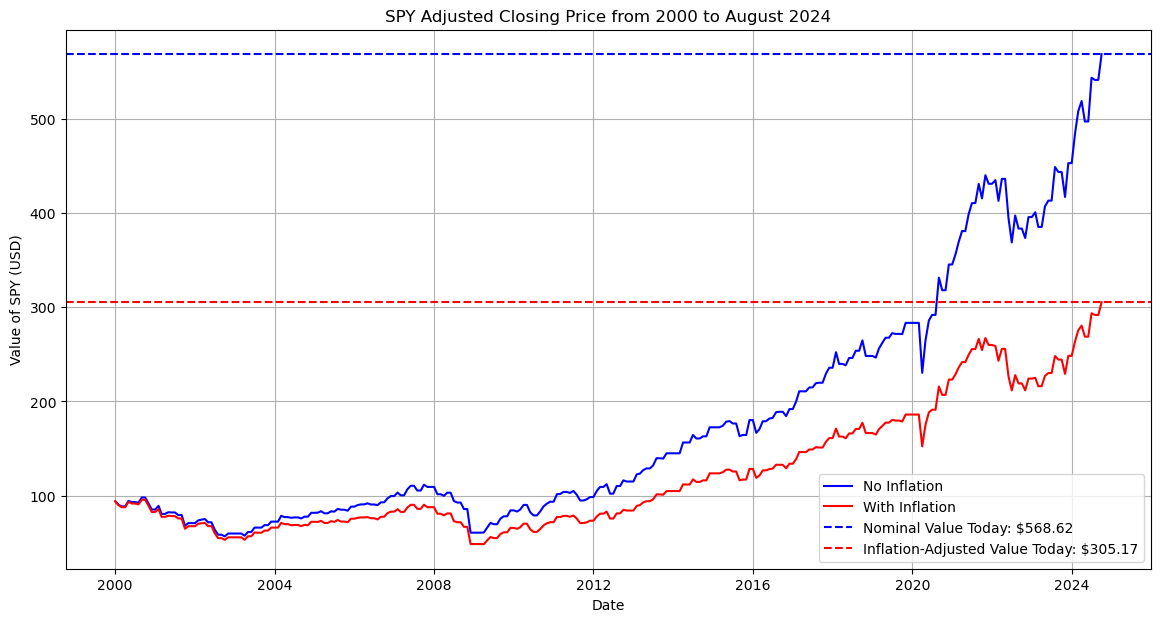

In [16]:
# 1 share of SPY - inflation vs no inflation

current_nominal_value = spy["close_price"].iloc[-1]
current_infl_adj_value = spy["real_price"].iloc[-1]

# Creating the plot
plt.figure(figsize=(14, 7))

# Plotting the SPY prices
plt.plot(spy["date"], spy["close_price"], color="blue", label="No Inflation")
plt.plot(spy["date"], spy["real_price"], color="red", label="With Inflation")

# Adding horizontal lines to highlight the current values
plt.axhline(
    y=current_nominal_value,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${current_nominal_value:,.2f}",
)
plt.axhline(
    y=current_infl_adj_value,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Inflation-Adjusted Value Today: ${current_infl_adj_value:,.2f}",
)

# Adding legend, labels, and title
plt.legend()
plt.title("SPY Adjusted Closing Price from 2000 to August 2024")
plt.xlabel("Date")
plt.ylabel("Value of SPY (USD)")
plt.grid(True)
plt.savefig("spy_1_diff.png")
# Show the plot
plt.show()

In [17]:
# Calculate inflation rate
cpi["infl_rate"] = ((cpi["cpi_value"] / cpi["cpi_value"].iloc[0]) - 1) * 100

# Constants
initial_investment = 10000  # $10,000
annual_interest_rate = 0.015  # 1.5% annual interest rate
monthly_interest_rate = annual_interest_rate / 12  # Monthly interest rate
number_of_months = len(cpi)  # Total number of months

# Nominal future value
nominal_future_value = (
    initial_investment * (1 + monthly_interest_rate) ** number_of_months
)

# Cumulative inflation factor
cumulative_inflation_rate = cpi["infl_rate"].iloc[-1]
cumulative_inflation_factor = 1 + (cumulative_inflation_rate / 100)

# Inflation-adjusted (real) value
real_value = nominal_future_value / cumulative_inflation_factor

# Prepare data for plotting
nominal_values = initial_investment * (1 + monthly_interest_rate) ** np.arange(len(cpi))
real_values = nominal_values / ((1 + (cpi["infl_rate"] / 100)).values)

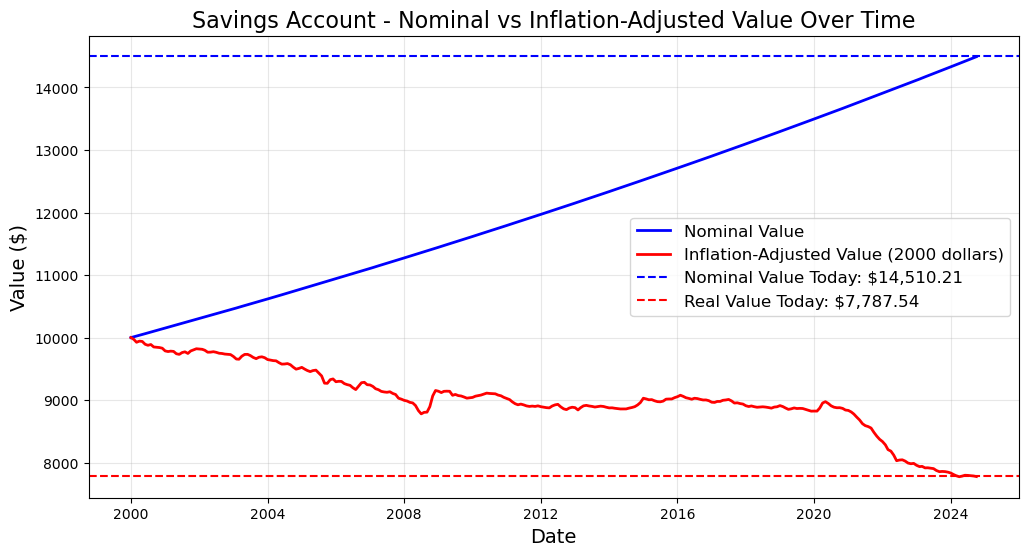

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(cpi["date"], nominal_values, label="Nominal Value", color="blue", linewidth=2)
plt.plot(
    cpi["date"],
    real_values,
    label="Inflation-Adjusted Value (2000 dollars)",
    color="red",
    linewidth=2,
)

# Add horizontal lines for today's nominal and real values
plt.axhline(
    y=nominal_future_value,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${nominal_future_value:,.2f}",
)
plt.axhline(
    y=real_value,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Real Value Today: ${real_value:,.2f}",
)

# Add labels, title, legend, and grid
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value ($)", fontsize=14)
plt.title(
    "Savings Account - Nominal vs Inflation-Adjusted Value Over Time", fontsize=16
)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Save the plot as a PNG file
plt.savefig("savings_account_plot.png", dpi=300)

# Display the plot
plt.show()

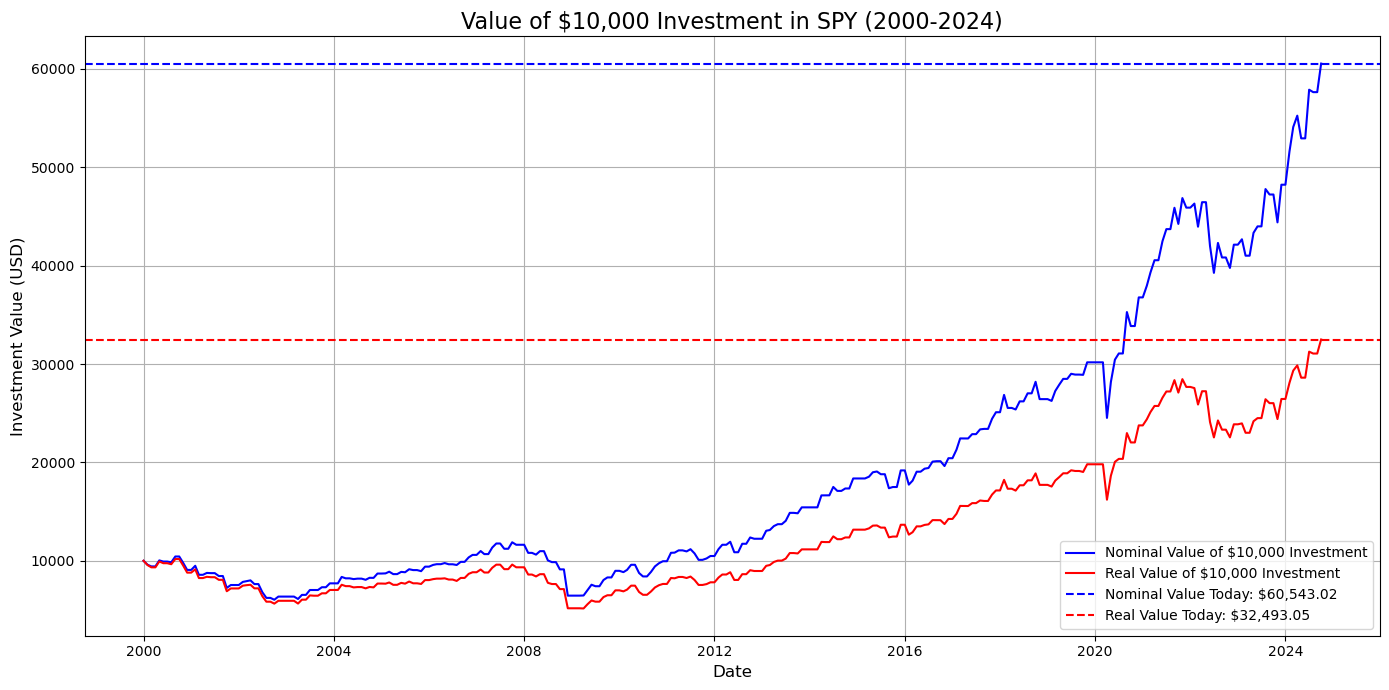

In [19]:
# Calculate the value of the investment over time
initial_investment = 10000  # Initial investment of $10,000
real_inv_10k = (spy["real_price"] / spy["real_price"].iloc[0]) * initial_investment
nominal_inv_10k = (spy["close_price"] / spy["close_price"].iloc[0]) * initial_investment

# Get the last values for axhline
nominal_value_today = nominal_inv_10k.iloc[-1]
real_value_today = real_inv_10k.iloc[-1]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the investment value over time
plt.plot(
    spy["date"],
    nominal_inv_10k,
    color="blue",
    label="Nominal Value of $10,000 Investment",
)
plt.plot(
    spy["date"], real_inv_10k, color="red", label="Real Value of $10,000 Investment"
)

# Add horizontal lines for the final values
plt.axhline(
    y=nominal_value_today,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${nominal_value_today:,.2f}",
)

plt.axhline(
    y=real_value_today,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Real Value Today: ${real_value_today:,.2f}",
)

# Set plot title and labels
plt.title("Value of $10,000 Investment in SPY (2000-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Investment Value (USD)", fontsize=12)
plt.legend()
plt.grid(True)

# Display Plot
plt.tight_layout()
plt.savefig("10k_spy.png")
plt.show()

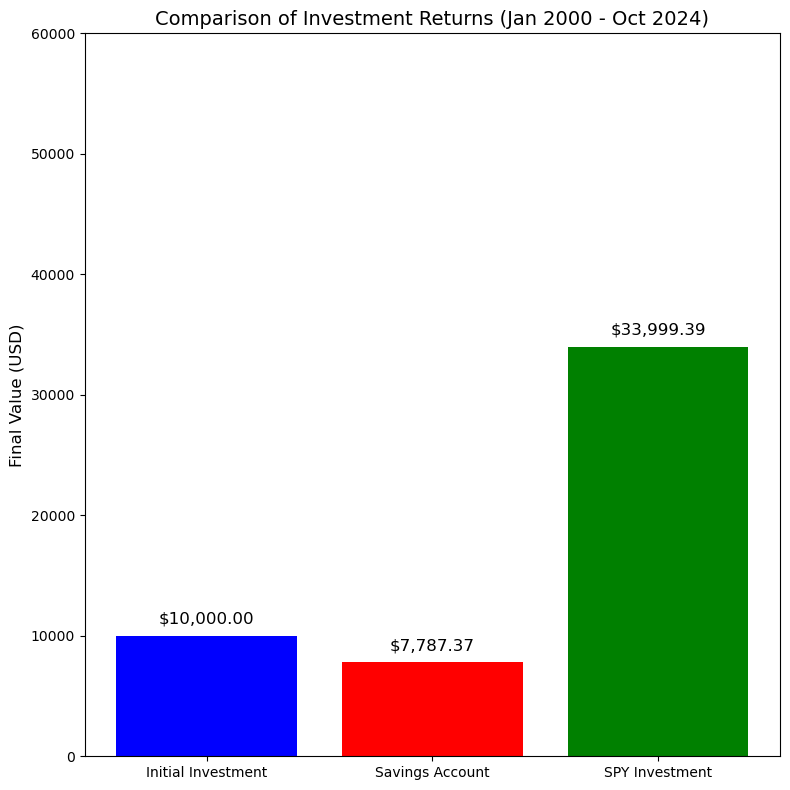

In [20]:
"""
Now given the returns from each medium, we visualise our returns
"""

spy_final_real_value = 33999.39
savings_final_real_value = 7787.37
initial_investment = 10000

categories = ["Initial Investment", "Savings Account", "SPY Investment"]
values = [initial_investment, savings_final_real_value, spy_final_real_value]

plt.figure(figsize=(8, 8))
plt.bar(categories, values, color=["blue", "red", "green"])

plt.title("Comparison of Investment Returns (Jan 2000 - Oct 2024)", fontsize=14)
plt.ylabel("Final Value (USD)", fontsize=12)
plt.ylim(0, 60000)


for i, v in enumerate(values):
    plt.text(i, v + 1000, f"${v:,.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("returns_10k.png")
plt.show()

In [21]:
"""
Make a new dataframe for inflation schedule contributions
Both schuedule contribution and SPY portfolio value must be adjusted to the 2000 price 
Then, calculating will be straightforward. 
"""

'\nMake a new dataframe for inflation schedule contributions\nBoth schuedule contribution and SPY portfolio value must be adjusted to the 2000 price \nThen, calculating will be straightforward. \n'

In [22]:
cpi

,date,cpi_value,adj_fac,infl_rate
0,2000-01-01,169.30,1.000000,0.000000
1,2000-02-01,170.00,0.995882,0.413467
2,2000-03-01,171.00,0.990058,1.004135
3,2000-04-01,170.90,0.990638,0.945068
4,2000-05-01,171.20,0.988902,1.122268
...,...,...,...,...
293,2024-06-01,313.05,0.540808,84.908447
294,2024-07-01,313.53,0.539980,85.191967
295,2024-08-01,314.12,0.538966,85.540461
296,2024-09-01,314.69,0.537990,85.877141


In [23]:
contribution_schedule = {
    "2000-01-01": 500,  # $500 monthly for 2 years (2000-2001)
    "2002-01-01": 1000,  # $1000 monthly for 2 years (2002-2003)
    "2004-01-01": 1500,  # $1500 monthly for 2 years (2004-2005)
    "2006-01-01": 2000,  # $2000 monthly from 2006 onwards
}


# Define a function to determine the contribution for a given date
def get_contribution(date, schedule):
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    for start_date, amount in sorted(schedule.items()):
        start_obj = datetime.strptime(start_date, "%Y-%m-%d")
        if date_obj >= start_obj:
            contribution = amount
    return contribution


# Initialize starting balance for 2000-01-01
balance = 10000
nominal_values = [
    round(balance, 2)
]  # Add the initial balance for the first month, rounded to 2 decimal places

# Monthly compounding rate
monthly_rate = 5.5 / 12 / 100  # Convert percentage to decimal

# Iterate through CPI DataFrame starting from the second row
for i, row in cpi.iterrows():
    if i == 0:  # Skip the first row (2000-01-01)
        continue

    date_str = row["date"].strftime("%Y-%m-%d")
    adj_fac = row["adj_fac"]

    # Get the contribution for the current date
    contribution = get_contribution(date_str, contribution_schedule)

    # Add the contribution to the balance
    balance += contribution

    # Compound the balance by the monthly rate
    balance *= 1 + monthly_rate

    # Append the nominal value (balance) for this month, rounded to 2 decimal places
    nominal_values.append(round(balance, 2))

# Add the nominal values to the CPI DataFrame
cpi["nominal_value"] = nominal_values
cpi["real_value"] = cpi["nominal_value"] * cpi["adj_fac"]

In [24]:
cpi["real_value"] = cpi["real_value"].round(2)
cpi

,date,cpi_value,adj_fac,infl_rate,nominal_value,real_value
0,2000-01-01,169.30,1.000000,0.000000,10000.00,10000.00
1,2000-02-01,170.00,0.995882,0.413467,10548.12,10504.69
2,2000-03-01,171.00,0.990058,1.004135,11098.76,10988.42
3,2000-04-01,170.90,0.990638,0.945068,11651.92,11542.83
4,2000-05-01,171.20,0.988902,1.122268,12207.62,12072.14
...,...,...,...,...,...,...
293,2024-06-01,313.05,0.540808,84.908447,1034974.07,559722.44
294,2024-07-01,313.53,0.539980,85.191967,1041726.87,562511.91
295,2024-08-01,314.12,0.538966,85.540461,1048510.61,565111.57
296,2024-09-01,314.69,0.537990,85.877141,1055325.45,567754.29


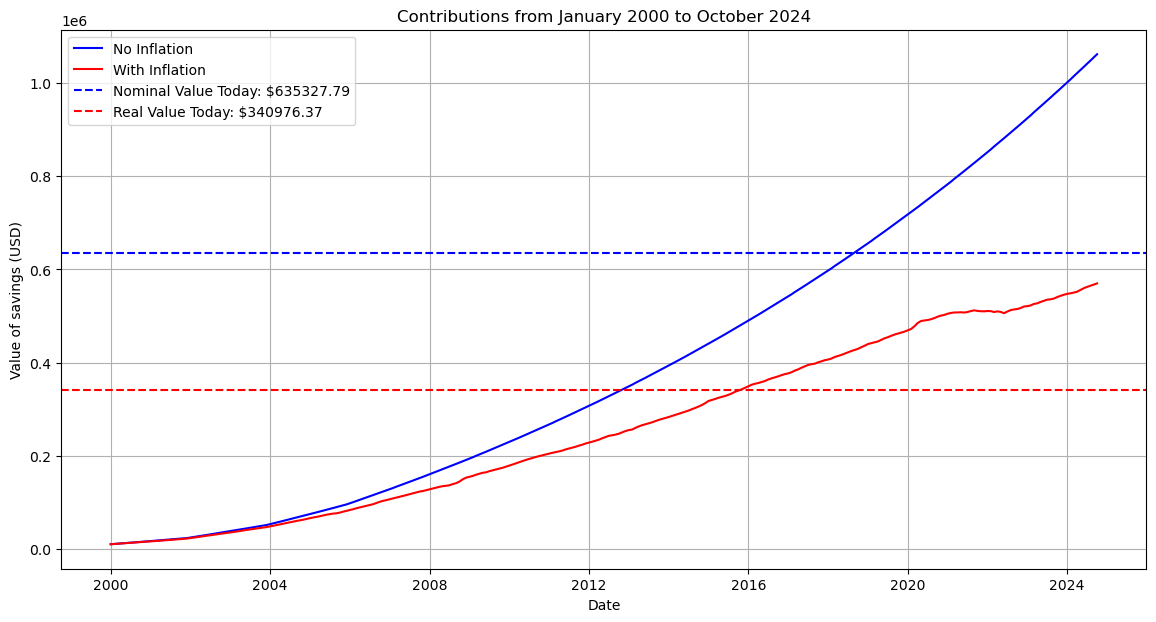

In [25]:
# Creating the plot
plt.figure(figsize=(14, 7))

# Plotting the SPY prices
plt.plot(cpi["date"], cpi["nominal_value"], color="blue", label="No Inflation")
plt.plot(cpi["date"], cpi["real_value"], color="red", label="With Inflation")

# Adding horizontal lines to highlight the current values
plt.axhline(
    y=635327.79,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label="Nominal Value Today: $635327.79",
)
plt.axhline(
    y=340976.37,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Real Value Today: $340976.37",
)

# Adding legend, labels, and title
plt.legend()
plt.title("Contributions from January 2000 to October 2024")
plt.xlabel("Date")
plt.ylabel("Value of savings (USD)")
plt.grid(True)
plt.savefig("savings_comparison_diff.png")
# Show the plot
plt.show()

In [26]:
spy

,date,close_price,adj_fac,real_price
0,2000-01-01,93.92,1.000000,93.920000
1,2000-02-01,90.13,0.995882,89.758876
2,2000-03-01,88.53,0.990058,87.649877
3,2000-04-01,88.53,0.990058,87.649877
4,2000-05-01,94.28,0.988902,93.233668
...,...,...,...,...
293,2024-06-01,497.22,0.540497,268.746116
294,2024-07-01,543.67,0.539980,293.571049
295,2024-08-01,541.35,0.538966,291.769244
296,2024-09-01,541.35,0.538966,291.769244


In [27]:
def get_contribution_2(date, schedule):
    contribution = 0
    for start_date, amount in sorted(schedule.items()):
        if date >= pd.Timestamp(start_date):
            contribution = amount
    return contribution


# Initialize tracking variables
starting_balance = 10000
nominal_invested = starting_balance
nominal_shares_owned = starting_balance / spy.loc[0, "close_price"]
nominal_values = [starting_balance]  # Initialize with starting balance
nominal_shares = [nominal_shares_owned]

# Iterate through SPY data starting from the second row
for i, row in spy.iterrows():
    if i == 0:
        continue  # Skip first row (starting balance already handled)

    date = row["date"]
    close_price = row["close_price"]  # Real SPY price

    # Get the contribution for this month
    contribution = get_contribution_2(date, contribution_schedule)

    # Buy SPY units with contribution
    shares_bought = contribution / close_price
    nominal_shares_owned += shares_bought

    # Update total invested
    nominal_invested += contribution

    # Calculate nominal value of SPY investment
    current_nominal_value = nominal_shares_owned * close_price
    nominal_values.append(current_nominal_value)
    nominal_shares.append(nominal_shares_owned)

# Add nominal values and shares to the DataFrame
spy["pf_nominal_value"] = nominal_values
spy["shares"] = nominal_shares


# Initialize tracking variables for real value
real_invested = starting_balance
real_shares_owned = starting_balance / spy.loc[0, "close_price"]
real_values = [starting_balance]  # Initialize with starting balance
real_shares = [real_shares_owned]

# Iterate through SPY data starting from the second row
for i, row in spy.iterrows():
    if i == 0:
        continue  # Skip first row (starting balance already handled)

    date = row["date"]
    close_price = row["close_price"]  # Real SPY price
    adj_fac = row["adj_fac"]  # Inflation adjustment factor

    # Get the contribution for this month
    contribution = get_contribution_2(date, contribution_schedule)

    # Adjust contribution to the real value
    contribution_real = contribution / adj_fac

    # Buy SPY units with adjusted contribution
    shares_bought = contribution_real / close_price
    real_shares_owned += shares_bought

    # Update total invested (nominal value of contributions)
    real_invested += contribution

    # Calculate real value of SPY investment
    current_real_value = real_shares_owned * close_price
    real_values.append(current_real_value)
    real_shares.append(real_shares_owned)

# Add real values and shares to the DataFrame
spy["pf_real_value"] = real_values

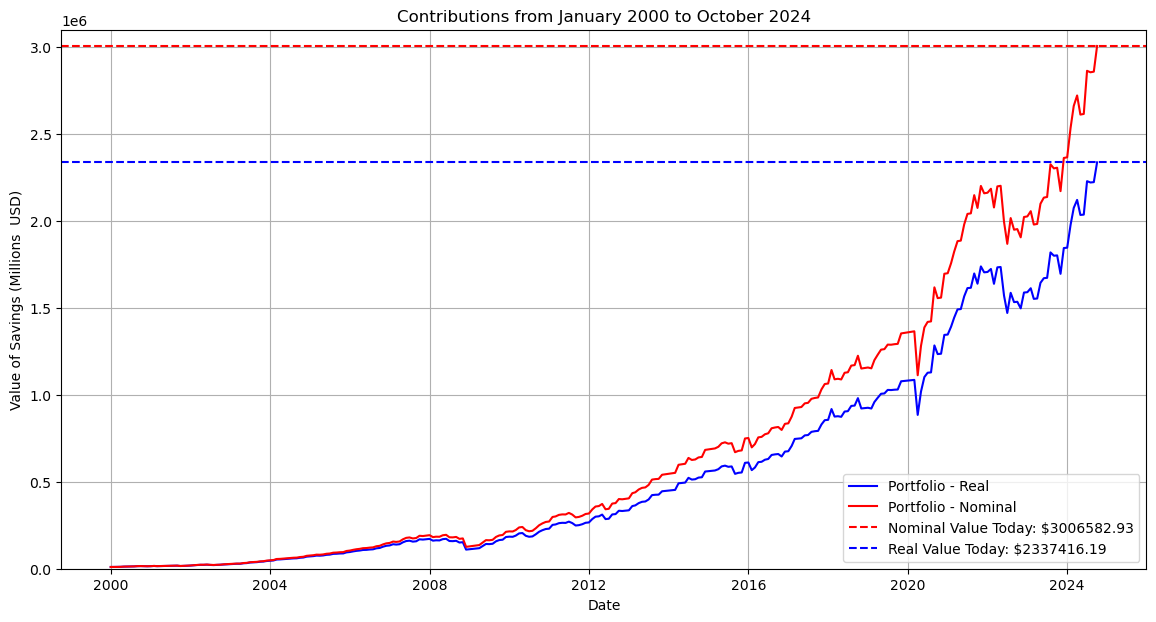

In [29]:
spy["pf_nominal_value"] = pd.to_numeric(spy["pf_nominal_value"], errors="coerce")
spy["pf_real_value"] = pd.to_numeric(spy["pf_real_value"], errors="coerce")

# Creating the plot
plt.figure(figsize=(14, 7))

# Plotting the SPY prices
plt.plot(spy["date"], spy["pf_nominal_value"], color="blue", label="Portfolio - Real")
plt.plot(spy["date"], spy["pf_real_value"], color="red", label="Portfolio - Nominal")

# Adding horizontal lines to highlight the current values
plt.axhline(
    y=3006582.93,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Nominal Value Today: $3006582.93",
)
plt.axhline(
    y=2337416.19,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label="Real Value Today: $2337416.19",
)

# Adding legend, labels, and title
plt.legend()
plt.ylim(0, 3100000)  # Set y-axis range based on data values
plt.title("Contributions from January 2000 to October 2024")
plt.xlabel("Date")
plt.ylabel("Value of Savings (Millions  USD)")
plt.grid(True)
plt.savefig("spy_comparison_diff.png")

# Show the plot
plt.show()

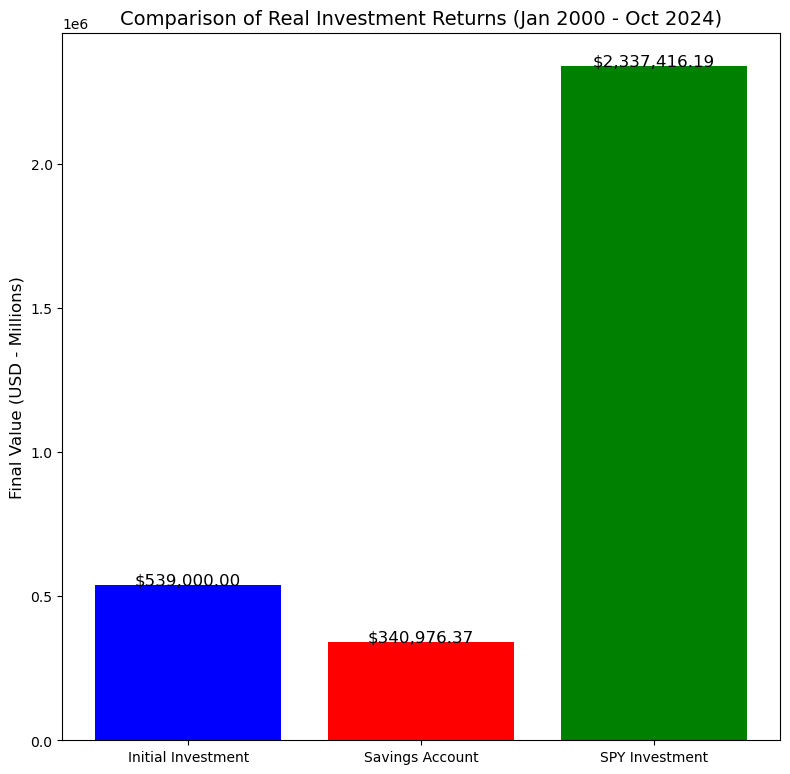

In [49]:
pf_final_real_value = 2337416.19
savings_final_real_value = 340976.37
total_investment = 539000

categories = ["Initial Investment", "Savings Account", "SPY Investment"]
values = [total_investment, savings_final_real_value, pf_final_real_value]

plt.figure(figsize=(8, 8))
plt.bar(categories, values, color=["blue", "red", "green"])

plt.title("Comparison of Real Investment Returns (Jan 2000 - Oct 2024)", fontsize=14)
plt.ylabel("Final Value (USD - Millions)", fontsize=12)


for i, v in enumerate(values):
    plt.text(i, v + 1000, f"${v:,.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("part-1.2-fig-6.2.png")
plt.show()

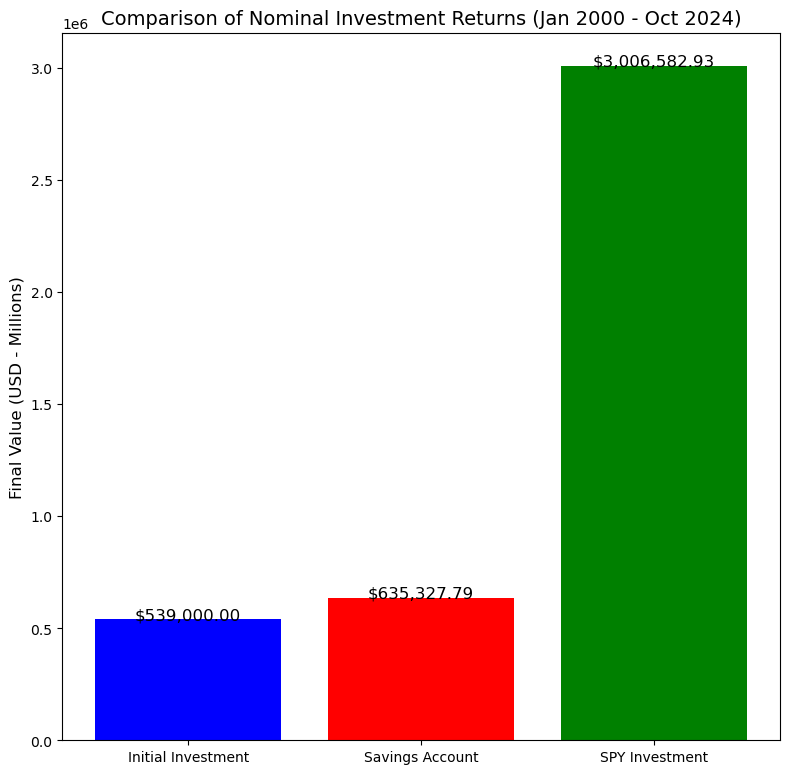

In [48]:
pf_final_nom_value = 3006582.93
savings_final_nom_value = 635327.79

categories = ["Initial Investment", "Savings Account", "SPY Investment"]
values = [total_investment, savings_final_nom_value,pf_final_nom_value]

plt.figure(figsize=(8, 8))
plt.bar(categories, values, color=["blue", "red", "green"])

plt.title("Comparison of Nominal Investment Returns (Jan 2000 - Oct 2024)", fontsize=14)
plt.ylabel("Final Value (USD - Millions)", fontsize=12)


for i, v in enumerate(values):
    plt.text(i, v + 1000, f"${v:,.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("part-1.2-fig-6.1.png")
plt.show()